In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas


from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, BoxStyle
from matplotlib.path import Path
import re
from pprint import pprint

thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'
#separated_roads_dir = output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())


#water_area_tol = 1 * 1000 * 1000
#overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

#scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver']
inverse_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'maroon', 'seagreen', 'black', 'red', 'black', 'black', 'black']

debug = 1
g = 0




def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 

def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator

# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield

road_label_format = { 
    'I': { 'labelsize': 14, 'thecolor': 'red', 'thebbox': dict(boxstyle="shield", fc='blue', ec='red') },     
    'U': { 'labelsize': 11, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 9, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 9, 'thecolor': 'black'},
    'O': { 'labelsize': 9, 'thecolor': 'red' }
}
print('ok')


ok


# Get congressional district shapefiles (nationwide)

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.7 seconds.


# Get block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 144.3 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 14.3 seconds!


## Get block group population data, join onto block group shapeifles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 4 seconds!


# Get what has already been matched

## From file (comment out if you haven't run this script before)

In [6]:
# s = time.time()
# print('reading districts that have been matched so far...')
# assembler_df = pandas.read_csv(data_dir+'raw_district_files/ak_to_mi_raw.csv', encoding='utf-8', index_col='GEOID')
# assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
# assembler_gdf.crs = bg_gdf.crs


# cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

# print('backing up...')
# cd_gdf_bk = cd_gdf
# bg_gdf_bk = bg_gdf
# assembler_gdf_bk = assembler_gdf

# e = time.time()
# g = g + (e-s)
# print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




## From scratch

In [7]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_13.csv', encoding='utf-8', index_col='GEOID')
#assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_14.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

# print('backing up...')
# cd_gdf_bk = cd_gdf
# bg_gdf_bk = bg_gdf
# assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
Kept 108,785 block groups in 2.0 seconds!


### Create a function to match districts

In [8]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')


defined district-marking function!


### Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [9]:
s = time.time()

for this_state in ['MI', 'GA']:
    print('File not found, reading from nationwide data...')
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)


    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        

    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')

    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))

    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1

    #assembler_i_gdf.to_file(output_dir+'raw_district_files/nj_raw.shp')

    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=True)
    if (debug > 0):
        print("\n")
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

# print('backing up...')
# assembler_gdf_justparsed = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Read {0:,.0f} rows in {1:,.0f} seconds!'.format(e-s, ))
print('Got {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T
#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()
assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


File not found, reading from nationwide data...


Processing Michigan...
	Assigning bitmask values to block groups in Michigan...
		processing row 1 of 8,205...
		processing row 101 of 8,205...
		processing row 201 of 8,205...
		processing row 301 of 8,205...
		processing row 401 of 8,205...
		processing row 501 of 8,205...
		processing row 601 of 8,205...
		processing row 701 of 8,205...
		processing row 801 of 8,205...
		processing row 901 of 8,205...
		processing row 1,001 of 8,205...
		processing row 1,101 of 8,205...
		processing row 1,201 of 8,205...
		processing row 1,301 of 8,205...
		processing row 1,401 of 8,205...
		processing row 1,501 of 8,205...
		processing row 1,601 of 8,205...
		processing row 1,701 of 8,205...
		processing row 1,801 of 8,205...
		processing row 1,901 of 8,205...
		processing row 2,001 of 8,205...
		processing row 2,101 of 8,205...
		processing row 2,201 of 8,205...
		processing row 2,301 of 8,205...
		processing row 2,401 of 8,205...
		processing row 

STUSAB
GA    14.0
MI    14.0
NC    13.0
NJ    12.0
VA    11.0
WA    10.0
IN     9.0
MA     9.0
AZ     9.0
TN     9.0
MO     8.0
WI     8.0
MD     8.0
MN     8.0
AL     7.0
CO     7.0
SC     7.0
KY     6.0
LA     6.0
CT     5.0
OR     5.0
OK     5.0
NV     4.0
IA     4.0
KS     4.0
MS     4.0
UT     4.0
AR     4.0
NM     3.0
WV     3.0
NE     3.0
ME     2.0
RI     2.0
ID     2.0
NH     2.0
HI     2.0
WY     1.0
DE     1.0
MT     1.0
ND     1.0
SD     1.0
VT     1.0
AK     1.0
Name: block_based_district, dtype: float64

## Match by hand

In [10]:
##### MICHIGAN
##       URBAN
assembler_gdf.loc[['15000US261614540002', '15000US261614550002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US261614550001'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US261251928001','15000US261251946001'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US261251946002'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US260992308001', '15000US260992308003', '15000US260992314001', '15000US260992330001', '15000US260992310001', '15000US260992309001'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US260992305003', '15000US260999820001', '15000US260992302004', '15000US260992325001', '15000US260992302003', '15000US260992309002'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US261251527001', '15000US261251801002', '15000US261251802001', '15000US261251802002'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US261251562002'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US261635727001', '15000US261635727002'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US261635727004'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US261635371001'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US261635107001', '15000US261635207002'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US261635055001', '15000US261635044001', '15000US261635044003', '15000US261635240001', '15000US261635110002', '15000US261635172002', '15000US261635213001', '15000US261635249001'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US261635123002', '15000US261635043001', '15000US261635043003', '15000US261635250001', '15000US261635168002', '15000US261635214001', '15000US261635231001', '15000US261635238001', '15000US261639852001'], 'block_based_district'] = 14
# ##      RURAL
assembler_gdf.loc[['15000US261059502002', '15000US261059502003'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US261059506001', '15000US261059506002', '15000US261059507001', '15000US261059503001', '15000US261059503002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US260810145023', '15000US260810145024', '15000US260810126051', '15000US260810126071'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US260810146011', '15000US260810147013', '15000US260810045001', '15000US260810045002', '15000US260810045003', '15000US260810045005', '15000US260810044004'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US260050322003', '15000US260050324011'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US260050322002', '15000US260050324021'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US261179712004', '15000US261179713004'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US261179711003', '15000US261179711004', '15000US261179712001', '15000US261179712002', '15000US261179712003', '15000US261179713002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US261450104033'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US261450103032', '15000US261450104032'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US261570003002'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US261570003004', '15000US261570009002'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US261570009004', '15000US261570010004', '15000US261570012002', '15000US261570012003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US261570007002'], 'block_based_district'] = 10


########## GEORGIA
assembler_gdf.loc[['15000US131850107001', '15000US131850101024', '15000US131850101012', '15000US131850101021', '15000US131850107002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US131850101022', '15000US131850101031', '15000US131850101011'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US131030303012','15000US131030304012', '15000US131030304021', '15000US131030302033'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US131030303031'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US132150104022', '15000US132150003001', '15000US132150003002', '15000US132150014001', '15000US132150111002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US132150102032', '15000US132150004001', '15000US132150004002', '15000US132150010001', '15000US132150102043'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US132150102031', '15000US132150103023', '15000US132150104021', '15000US132150002001' ], 'block_based_district'] = 3
assembler_gdf.loc[['15000US130210122002','15000US130210123003', '15000US130210119002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US130210121011'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US132150018001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US132150008001', '15000US132150009002', '15000US132150014002', '15000US132150112001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US130210102003', '15000US130210134102'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US130210122001', '15000US130210136051'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US131510704031', '15000US131510704032', '15000US131510703042', '15000US131510704042', '15000US131510703071' ], 'block_based_district'] = 3
assembler_gdf.loc[['15000US131510703043', '15000US131510703041', '15000US131510704033'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US131131403051', '15000US131510705012'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US131510702051', '15000US131131404032', '15000US131131404033', '15000US131131404041', '15000US131131404061', '15000US131131404062', '15000US131131402042'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US131510703091', '15000US131510705023', '15000US131510705021', '15000US131510705023', '15000US131131402043'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US130890235011', '15000US130890235051', '15000US130890234123', '15000US130890216022', '15000US130890216042'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US130890229001', '15000US130890226002', '15000US130890226003', '15000US130890234122', '15000US130890234221'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US130890215042', '15000US130890234222', '15000US130890234131', '15000US130890228003', '15000US130890234121'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US130890216051', '15000US130890216053', '15000US130890217032', '15000US130890218092', '15000US130890218103'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US131350504171', '15000US131350504253', '15000US131350504284', '15000US131350507211', '15000US131350507213', '15000US131350507311', '15000US131350504101', '15000US131350504272', '15000US131350507152'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US131350504211', '15000US131350507184'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US132171006001', '15000US132171008002', '15000US132171001004', '15000US132171003001', '15000US132171003003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US132171002013'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US130890214152'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US131210097003', '15000US131210098011', '15000US131210098012', '15000US131210099003', '15000US131210100023'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US130630404123', '15000US130630406163', '15000US130630402021', '15000US130630405222', '15000US130630404161', '15000US130630404141', '15000US131210103041', '15000US131210106043', '15000US131210113053'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US131210103042', '15000US131210113062', '15000US130630405091', '15000US130630404153'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US131210101151', '15000US130670305062', '15000US130670304054', '15000US130670305022', '15000US130670305054', '15000US131210102123'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US131210101142', '15000US131210101143', '15000US130670303392', '15000US130670303442', '15000US130670303451', '15000US130670304081', '15000US130670305061'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US131171302053', '15000US131171303071', '15000US131171304032', '15000US131171303053', '15000US131171304033'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US131171303011', '15000US131171304031', '15000US131171302053', '15000US131171302051'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US131350506052', '15000US131350506091', '15000US131350505461'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US131350506093', '15000US131350506071', '15000US131350506072',  '15000US131350506083', '15000US131350507261'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US130591303002', '15000US130591405001'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US130591406002'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US132270506003'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US132270503001', '15000US132270503002', '15000US132270505001', '15000US132270505002'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US130730303082', '15000US130730304023'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US130730304021', '15000US130730305032', '15000US130730303081', '15000US130730303092', '15000US130730305033'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US131510702023', '15000US131510702042', '15000US131510702052'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US130670310012', '15000US130670311081', '15000US130670310042', '15000US130670310043'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US130670315031', '15000US130670315032', '15000US130670315033', '15000US130670315061', '15000US130670310021', '15000US130670311183', '15000US130670312063'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US130670310013', '15000US130670310023', '15000US130670311182', '15000US130670312051'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US130670311121', '15000US130670312061', '15000US130670312062'], 'block_based_district'] = 13


print('ok')

ok


# WRITE OUTPUT

In [11]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_14.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 122,692 block groups in 0 minutes 4 seconds!
GRAND TOTAL TIME: 39  minutes 5 seconds!


# Test whether output wrote correctly

In [12]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_14.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')

e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))



	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 138.1 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 6.3 seconds


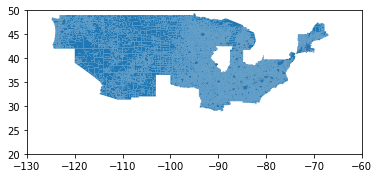

In [13]:
fig,ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.xlim(-130,-60)
plt.ylim(20,50)
plt.show()



## GEORGIA

In [14]:


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'GA')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # congressional_districts_bitmask
# # x10000001000000     8
# # x10000000000100     5
# # x01100000000000    19
# # x01000001000000     8
# # x00100000010000     8
# # x00100000000010    13
# # x00011000000000    15
# # x00010100000000     5
# # x00010010000000    11
# # x00010000010000     6
# # x00001100000000     1
# # x00001000001000     5
# # x00001000000010    13
# # x00000100001000    13
# # x00000010100000     8
# # x00000010010000     8
# # x00000000110000     3
# # x00000000100001     5
# # x00000000010100     7
# # x00000000010010     3
# # x00000000001010    18


In [15]:
# s = time.time()

# this_state = 'GA'
# this_state_number = 13
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# old_map_buffer_ratio = -1

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



In [16]:
# s = time.time()

# this_state = 'GA'
# test_this_bitmask = 'x00000000001010'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# manual_xlim = (-84.45,-84.32)
# manual_ylim = (33.57,33.64)


# legend_location = 'lower left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     & (assembler_gdf.index != '15000US180973209033')
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & (place_gdf['NAME'].isin(['Paradise Valley']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
#                    )

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



## Examine closely

In [17]:
# s = time.time()

# label_small_roads = True
# label_small_road_types = ['Dr','St','Rd','Ave','Blvd']
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1
 
# i = 6

# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US131131402042'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('DISTRICT {0:}'.format(j))
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))

#         cd_gdf[
#             (cd_gdf['STUSAB'] == this_state) 
#             & (cd_gdf['CD116FP'] == j)
#         ].plot(ax=ax, color=district_color_cycle[j-1])
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j-1], label='District {0:,.0f}'.format(j)))
# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.25)
# roads_in_map_area_gdf[~roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=4)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='red', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
# #    pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)




# MICHIGAN

## Get water areas, etc for whole state

In [18]:
# s = time.time()

# this_state = 'MI'
# this_state_number = 26
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# old_map_buffer_ratio = -1

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



# Define urban area

Urban = Detroit metro area, with Livingston County at NW corner

Rural = Rest of state

In [19]:
# s = time.time()
# urban_west_limit = unary_union(assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'MI') & (assembler_gdf['COUNTY_NAME'] == 'Livingston County')
# ].geometry.tolist()).bounds[0]

# urban_north_limit = unary_union(assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'MI') & (assembler_gdf['COUNTY_NAME'] == 'Livingston County')
# ].geometry.tolist()).bounds[3]

# urban_south_limit = unary_union(
#     assembler_gdf[(assembler_gdf['STUSAB'] == 'MI')].geometry.tolist()
# ).bounds[1]

# urban_east_limit = unary_union(
#     assembler_gdf[(assembler_gdf['STUSAB'] == 'MI')].geometry.tolist()
# ).bounds[2]

# xlim = [urban_west_limit, urban_east_limit]
# ylim = [urban_south_limit, urban_north_limit]

# urban_geo = makebox(xlim, ylim)
# #urban_geo_gdf = geopandas.GeoDataFrame(data=[[urban_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} seconds!'.format(e-s))

### Splitting water, places, roads into urban/rural

In [20]:
# s = time.time()
# print('splitting water areas...')
# water_urban_gdf = water_gdf[water_gdf.geometry.within(urban_geo)]
# water_rural_gdf = water_gdf[~water_gdf.geometry.within(urban_geo)]

# print('splitting places...')
# place_urban_gdf = place_gdf[place_gdf.geometry.within(urban_geo)]
# place_rural_gdf = place_gdf[~place_gdf.geometry.within(urban_geo)]


# print('splitting roads...')
# roads_urban_gdf = roads_gdf[roads_gdf.geometry.within(urban_geo)]
# roads_rural_gdf = roads_gdf[~roads_gdf.geometry.within(urban_geo)]
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} seconds!'.format(e-s))

### Shifting bitmasks in urban area

In [21]:
# s = time.time()

# if ('bitmask_shifted' in assembler_gdf.columns):
#     assembler_gdf = assembler_gdf.drop('bitmask_shifted', axis=1)
    
# nDistrictsInState = int(assembler_gdf['block_based_district'].max())
# lowest_district_in_urban_area = int(assembler_gdf[
#     (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
#     & (assembler_gdf['block_based_district'] > 0)
# ]['block_based_district'].min())

# assembler_gdf = assembler_gdf.assign(bitmask_shifted = np.nan)

# assembler_gdf.loc[
#     (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo))) & (assembler_gdf['block_based_district'] == -1), 
#     'bitmask_shifted'] = assembler_gdf[
#     (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
#     & (assembler_gdf['block_based_district'] == -1)
# ]['congressional_districts_bitmask'].apply(lambda x: 'x'+x[lowest_district_in_urban_area:])

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} seconds!'.format(e-s))


## Urban establishing shot

In [22]:
# show_plot = False

# if (show_plot):
#     fig, ax = plt.subplots(1,1)
#     legend_location = 'lower right'

#     legend_list = []
#     for i in range(lowest_district_in_urban_area,nDistrictsInState+1):
#         assembler_gdf[
#             (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i-1,10)])
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i-1,10)], label='District {0:,.0f}'.format(i)))
#     # for i in range(1, len(test_this_bitmask)):
#     #     if (test_this_bitmask[i] == '1'):
#     #         assembler_gdf[
#     #             (assembler_gdf['block_based_district'] == i)
#     #             & 
#     #             (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
#     #         ].plot(column='block_based_district', ax=ax, color=district_color_cycle[i])
#     water_urban_gdf.plot(ax=ax, color='blue')



#     assembler_gdf[
#         (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
#         & (assembler_gdf['block_based_district'] == -1)
#     ].plot(ax=ax, color='black')

#     plt.title('Urban area: Establing shot')
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
#     plt.show()


# assembler_gdf[
#     (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('bitmask_shifted').size().sort_index(ascending=False)

# # congressional_districts_bitmask
# # 7 and 12 (x00000010000100)      3
# # 8 and 11 (x00000001001000)      3
# # 9 and 10 (x00000000110000      12
# # 9 and 11 (x00000000101000)      4
# # 11 and 14 (x00000000001001)     1
# # 12 and 13 (x00000000000110)     3
# # 13 and 14 (x00000000000011)    20

# #bitmask_shifted
# # 7 and 12 (x10000100)     3
# # 8 and 11 (x01001000)     3
# # x00110000    12
# # x00101000     4
# # x00001001     1
# # x00000110     3
# # x00000011    20

# #assembler_gdf['bitmask_shifted'].dropna().apply(lambda x: x[0]+'00000'+x[1:])

## URBAN: examine and match

In [23]:
# s = time.time()

# this_state = 'MI'
# test_this_shifted_bitmask = 'x00000011'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = False

# manual_xlim = (-83,-82.965)
# manual_ylim = (42.39,42.42)

# legend_location = 'lower right'

# map_buffer_ratio = .2

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_shifted_bitmask)):
#         if (test_this_shifted_bitmask[i] == '1'):
# #            print('District {0:.0f}'.format(i+lowest_district_in_urban_area-1))
# #            print(district_color_cycle[i+lowest_district_in_urban_area-1-1])
#             cd_gdf[
#                 (cd_gdf['STUSAB'] == this_state) 
#                 & (cd_gdf['CD116FP'] == i+lowest_district_in_urban_area-1)
#             ].plot(ax=ax, color=district_color_cycle[i+lowest_district_in_urban_area-1-1])
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i+lowest_district_in_urban_area-1-1], label='District {0:,.0f}'.format(i+lowest_district_in_urban_area-1)))
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
        
# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1, ax2):
    
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['bitmask_shifted'] == test_this_shifted_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)    
    
#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#                 assembler_gdf[
#                     (assembler_gdf['block_based_district'] == -1)
#                     & (assembler_gdf['bitmask_shifted'] == test_this_shifted_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
    
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)

# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['bitmask_shifted'] == test_this_shifted_bitmask)
#    & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#    & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

    
# if (show_water):
#     print('plotting water...')
#     water_urban_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_urban_gdf[roads_urban_gdf['RTTYP'].isnull()].plot(ax=ax2, color='red', linewidth=0.25)
#     roads_urban_gdf[~roads_urban_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'C'].plot(ax=ax2, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'S'].plot(ax=ax2, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'U'].plot(ax=ax2, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'I'].plot(ax=ax2, color=road_label_format['I']['thecolor'], linewidth=4)


# # if (show_places):
# #     print('plotting places...')
# #     place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
# #     for ix, thisrow in place_gdf[
# #         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
# #         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
# #         & (place_gdf['NAME'].isin(['Paradise Valley']))
# #     ].sort_values(by='NAME').iterrows():
# #         print('\t{0:}...'.format(thisrow['NAME']))
# #         annotator = thisrow['NAME'].upper()
# #         ax2.annotate(annotator, 
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
# #                    )
        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


## URBAN - EXAMINE CLOSELY

In [24]:

# s = time.time()

# label_small_roads = True
# label_small_road_types = ['Ave','St'] #['Pkwy', 'St', 'Way', 'Dr', 'Blvd', 'Rd']
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1
 
# i = 8  # up to 8

# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US261635371001'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_shifted_bitmask)):
#     if (test_this_shifted_bitmask[j] == '1'):
#         cd_gdf[
#             (cd_gdf['STUSAB'] == this_state) 
#             & (cd_gdf['CD116FP'] == j+lowest_district_in_urban_area-1)
#         ].plot(ax=ax, color=district_color_cycle[j+lowest_district_in_urban_area-1-1])
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j+lowest_district_in_urban_area-1-1], label='District {0:,.0f}'.format(j+lowest_district_in_urban_area-1)))
# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_urban_gdf[water_urban_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_urban_gdf[roads_urban_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_urban_gdf[roads_urban_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.25)
# roads_in_map_area_gdf[~roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=4)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='red', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)
# # ''

## Rural estalishing shot

In [25]:
# show_plot = False
# if (show_plot):
#     fig, ax = plt.subplots(1,1,figsize=(8,8))
#     legend_location = 'lower left'

#     legend_list = []
#     for i in range(1, nDistrictsInState+1):
#         if (len(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf.geometry.apply(lambda x: ~x.within(urban_geo))) & (assembler_gdf['block_based_district'] == i)]) > 0):        
#             assembler_gdf[
#                 (assembler_gdf['STUSAB'] == this_state)
#                 & (assembler_gdf.geometry.apply(lambda x: ~x.within(urban_geo)))             
#                 & (assembler_gdf['block_based_district'] == i)
#             ].plot(ax=ax, color=district_color_cycle[i-1])
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))

#     water_rural_gdf.plot(ax=ax, color='blue')
    
#     assembler_gdf[
#         (assembler_gdf['STUSAB'] == this_state)
#         & (assembler_gdf.geometry.apply(lambda x: ~x.within(urban_geo)))
#         & (assembler_gdf['block_based_district'] == -1)
#     ].plot(ax=ax, color='black')

#     plt.title('Urban area: Establing shot')
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
#     plt.show()
    
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: ~x.within(urban_geo)))
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# #congressional_districts_bitmask
# # x11000000000000     7
# # x01100000000000    11
# # x01000100000000     4
# # x00110000000000     8
# # x00011000000000     3
# # x00001000010000     8
    

## RURAL: examine and match

In [26]:
# s = time.time()

# this_state = 'MI'
# test_this_bitmask = 'x00001000010000'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# manual_xlim = (-80.9,-80.79)
# manual_ylim = (35,35.11)


# legend_location = 'upper right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['STUSAB'] == this_state)
#         & (assembler_gdf.geometry.apply(lambda x: ~x.within(urban_geo)))
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

    
#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     & (assembler_gdf.index != '15000US180973209033')
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_rural_gdf.plot(ax=ax2, color='blue')


# print('plotting roads...')
# if (show_small_roads):
#     roads_rural_gdf[roads_rural_gdf['RTTYP'].isnull()].plot(ax=ax2, color='red', linewidth=0.25)
#     roads_rural_gdf[~roads_rural_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'C'].plot(ax=ax2, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'S'].plot(ax=ax2, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'U'].plot(ax=ax2, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'I'].plot(ax=ax2, color=road_label_format['I']['thecolor'], linewidth=4)
    
# if (show_places):
#     print('plotting places...')
#     place_rural_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_rural_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_rural_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_rural_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_rural_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
#                    )
        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


## Rural - examine closely

In [27]:
# s = time.time()

# label_small_roads = True
# label_small_road_types = ['Rd','Dr','St'] #['Pkwy', 'St', 'Way', 'Dr', 'Blvd', 'Rd']
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1
 
# i = 4 # up to 4

# map_buffer_ratio = .25

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US261635371001'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         cd_gdf[
#             (cd_gdf['STUSAB'] == this_state) 
#             & (cd_gdf['CD116FP'] == j)
#         ].plot(ax=ax, color=district_color_cycle[j-1])
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j-1], label='District {0:,.0f}'.format(j)))
# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_rural_gdf[water_rural_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_rural_gdf[roads_rural_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_rural_gdf[roads_rural_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.25)
# roads_in_map_area_gdf[~roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=0.25)

# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=0.5)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=1)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=1.5)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=4)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='red', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)
